In [1]:
try:
  import google.colab
  IN_COLAB = True
  
  # # If using colab
  # from google.colab import drive
  # drive.mount('/content/drive')

  # import os
  # os.chdir('/content/drive/My Drive/Colab Notebooks/EBA5004')
  # print('Working directory changed to ' + os.getcwd())

except:
  IN_COLAB = False


In [ ]:
%%capture
# Install dependencies -chromium, its driver, and selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium
!pip install pyvirtualdisplay
!sudo apt-get install xvfb

In [1]:
from bs4 import BeautifulSoup as s
import pandas as pd
import re
from tqdm import tqdm

# set options to be headless
from selenium import webdriver

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
# driver = webdriver.Chrome('chromedriver', chrome_options=chrome_options)

# function definitions
def web_browser(web):
    # browser = webdriver.Safari()
    browser = webdriver.Chrome('chromedriver_79', options=chrome_options)
    browser.get(web)
    content = browser.page_source
    return content

def updateDict(dict, key, desc, src, bPreferShort = True):
    
    # preprocess key to remove unwanted characters such as ',",®, etc
    k = re.sub('[^\w\-\.\/]+',' ', key.lower()).strip()

    # update value (choose shorter/longer value if exists)
    if k in dict and (len(desc) > len(dict[k]['desc']) if bPreferShort else len(desc) < len(dict[k]['desc'])): 
      return

    dict[k] = {
        'desc': desc,
        'src': src
    }

def getDetailsDict(dict):
  print('Dictionary: ')
  print(' num keys: ', len(dict))

  v = list(dict.values())
  unique_src = set([ t['src'] for t in v])
  print(' sources:', unique_src)


## Scrape Data

In [13]:
# Scrape from headphones.com
url="https://www.headphones.com/pages/glossary"
webpage = web_browser(url)
soup = s(webpage,'html.parser')
# print(soup.get_text())

glossary = {}

glossary_1 = {}
soupGlossary = s(str(soup))
for i,p in enumerate(soupGlossary.select("div.rte.rte--nomargin p")):
    if len(p.select("b")) != 0: 
        t = p.find("b").extract()

        if (p.text.strip() != ''):
            k = t.text.strip().lower()
            v = p.text.strip()
            updateDict(glossary_1, k, v, url)
            updateDict(glossary, k, v, url)

getDetailsDict(glossary)

Dictionary:
 num keys:63
 sources:{'https://www.headphones.com/pages/glossary'}


In [14]:
# Scrape from https://www.crutchfield.com/S-P3Fy2Oh1DMm/learn/headphones-glossary.html
# -- Note: This site has very poorly formatted HTML pages, which makes scrapping very troublesome and difficult
from bs4 import BeautifulSoup, NavigableString, Tag

url="https://www.crutchfield.com/S-P3Fy2Oh1DMm/learn/headphones-glossary.html"
webpage = web_browser(url)
soup = s(webpage,'html.parser')
# print(soup.get_text())

glossary_2 = {}
soupGlossary = s(str(soup))
for i,p in enumerate(soupGlossary.select("div#jump p")):
    bt = p.select("span.boldText")

    if len(bt) != 0: 
        nextSibling = bt[0].nextSibling

        # exclude it when the boldText is used for emphasis instead of as a heading.. zz
        if not isinstance(nextSibling, NavigableString):       
            k = bt[0].text.strip().lower()
            bt[0].extract()
            v = p.text.strip()

            if (len(v) != 0): 
                updateDict(glossary_2, k, v, url)
                updateDict(glossary, k, v, url)

getDetailsDict(glossary)

Dictionary:
 num keys:94
 sources:{'https://www.headphones.com/pages/glossary', 'https://www.crutchfield.com/S-P3Fy2Oh1DMm/learn/headphones-glossary.html'}


In [15]:
# Scrape from https://krisp.ai/blog/glossary-headphone-terms/
from bs4 import BeautifulSoup, NavigableString, Tag
import re

url = "https://krisp.ai/blog/glossary-headphone-terms/"
webpage = web_browser(url)
soup = s(webpage, 'html.parser')

glossary_3 = {}
soupGlossary = s(str(soup))
for i,p in enumerate(soupGlossary.select("div.post_content h2")):
    k = re.sub(r'[0-9]*\)\s', '', p.text.strip()) # get key - remove numbering prefix
    # print(p.text)

    # loop through sibling to retrieve description until next h2
    nextNode = p
    v_arr = []
    while True:
        nextNode = nextNode.nextSibling
        if nextNode is None: break
        # if isinstance(nextNode, NavigableString): print(nextNode.strip())
        if isinstance(nextNode, Tag):
            if nextNode.name == "h2": break
            v_arr.append(nextNode.get_text(strip=False).strip())
  
    # print(' '.join(v_arr).strip())
    v = ''.join(v_arr).strip()

    updateDict(glossary_3, k, v, url)
    updateDict(glossary, k, v, url)

getDetailsDict(glossary)


Dictionary:
 num keys:116
 sources:{'https://www.headphones.com/pages/glossary', 'https://www.crutchfield.com/S-P3Fy2Oh1DMm/learn/headphones-glossary.html', 'https://krisp.ai/blog/glossary-headphone-terms/'}


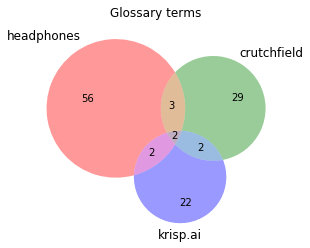

In [12]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

intersect12 = len(set(glossary_1).intersection(glossary_2))
intersect13 = len(set(glossary_1).intersection(glossary_3))
intersect23 = len(set(glossary_2).intersection(glossary_3))
intersect123 = len(set(glossary_1).intersection(glossary_2).intersection(glossary_3))

v1 = len(glossary_1) - intersect12 - intersect13 + intersect123
v2 = len(glossary_2) - intersect12 - intersect23 + intersect123
v3 = len(glossary_3) - intersect13 - intersect23 + intersect123
v12 = intersect12 - intersect123
v13 = intersect13 - intersect123
v23 = intersect23 - intersect123
v123 = intersect123

venn3(subsets=(v1, v2, v12, v3, v13, v23, v123), set_labels=('headphones', 'crutchfield', 'krisp.ai'))
plt.title('Glossary terms')
plt.show()

In [23]:
print(list(glossary.keys()))

['analog', 'balanced headphones', 'behind-the-neck', 'bright', 'circumaural', 'closed', 'coaxial', 'coherent', 'crossfeed', 'dac', 'damping factor', 'dbr', 'digital', 'digital inputs', 'distortion', 'driver', 'ear headphone', 'earbud', 'earpad', 'efficiency', 'filter switch', 'frequency response', 'full size', 'gain switch', 'harmonic distortion', 'headphone amplifier', 'headphone efficiency', 'headphone sensitivity', 'image depth', 'image width', 'imaging', 'impedance', 'in-ear monitor', 'input impedance', 'isolation', 'laid back', 'linear amplifier', 'liquid sounding', 'listening fatigue', 'lush', 'op-amp', 'opa 627', 'open', 'optical', 'otl tube amps', 'output impedance', 'power amplifier', 'power supply', 'punch', 'resonance', 's/pdif', 'sealed', 'self-powered speakers', 'solid state', 'soundstage', 'square wave response', 'supra-aural', 'transient response', 'transistor', 'tube amplifier', 'usb', 'warmth', 'wireless', '2.4 ghz', 'airline adapter', 'armature', 'around-the-ear', 'as

## Export data

In [0]:
import pandas as pd

# convert dict to list of tuples
glossary_list = list(zip(glossary.keys(), glossary.values()))
glossary_tuple = [ (t[0], t[1]['desc'], t[1]['src']) for t in glossary_list]
glossary_tuple = sorted(glossary_tuple, key=lambda x: x[0], reverse=False)

# save in excel
df = pd.DataFrame(glossary_tuple, columns=['Term', 'Description', 'Source'])
df.to_excel('glossary.xls')

# save pickle (time-stamp filename just in case, sites are blocked or are changed)
from datetime import datetime
import pickle
suffix = datetime.now().strftime("%Y_%m_%d")
with open('glossary_' + suffix + '.pickle', 'wb') as handle:
    pickle.dump(glossary, handle, protocol=pickle.HIGHEST_PROTOCOL)


## Testing

In [0]:
import pickle
import glob
# load most recent pickle file
mypickle = sorted(glob.glob('./glossary_*.pickle'), reverse=True)
with open(mypickle[0], 'rb') as handle:
  glossary = pickle.load(handle)

### Word similarity

In [0]:
%%capture
# Get spacy models
!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_md

In [0]:
# Get similarity of two words - query term vs glossary term
if IN_COLAB:
  import en_core_web_md
  nlp = en_core_web_md.load()
else:
  import spacy 
  nlp = spacy.load('en_core_web_md') 

In [0]:
stop_words = [] # to add if necessary
query = 'in ear monitor'

# pre-process query
query_nlp = nlp(query)
query_no_stop_nlp = nlp(' '.join([t.text for t in query_nlp if t.text.lower() not in stop_words]))

# compare with our glossary
keys_nlp = [nlp(k) for k in list(glossary.keys())]
similarity_nlp = [(k, query_no_stop_nlp.similarity(k)) for k in keys_nlp]
results = sorted(similarity_nlp, key=lambda x: x[1], reverse=True)
print(results)

# return description for top results
print('Query:', query)
print('Result:', glossary[results[0][0].text]['desc'])

[(in-ear monitor, 0.923780920833621), (in-ear, 0.7657072884595223), (over-ear, 0.6971400142243328), (ear headphone, 0.6746689610199131), (in-the-ear, 0.670699913251981), (on-ear, 0.6645468958381086), (ear clips, 0.6496424273310502), (around-the-ear, 0.6418729406675013), (ear hangers, 0.6362281562916151), (biaural or binaural, 0.6356913652869836), (on-the-ear, 0.607228467157929), (virtual surround sound, 0.5722404131729087), (binaural recording, 0.5692446755143804), (headphone sensitivity, 0.5608975877053368), (balanced headphones, 0.5524378211388962), (portable headphones, 0.5414444348146429), (custom earphones, 0.5399969324642944), (behind-the-neck, 0.5311743960727074), (frequency response, 0.5287875285996619), (sport headphones, 0.5287825550868984), (noise cancelling headphones, 0.5263969817200289), (noise attenuation, 0.5245994629592661), (square wave response, 0.5129230763278021), (noise-isolating, 0.5103457957079598), (boom microphone, 0.5072525959043113), (headphone efficiency, 0

### Question Answering Model

Question Answering with Pretrained BERT model on SQuAD dataset

See http://docs.deeppavlov.ai/en/master/features/models/squad.html#

In [0]:
!pip install deeppavlov
!pip install email-validator
!python -m deeppavlov install squad_bert

In [0]:
from deeppavlov import build_model, configs
model = build_model(configs.squad.squad, download=True) # Default, but assumes answer is within context
model_noans = build_model(configs.squad.multi_squad_noans, download=True) # SQuAD with contexts without correct answers


In [0]:
def getAnswer(c, queries, prettify=True):
  print('*'*80)
  print('Context: ', c)
  for q in queries:
    a1 = model(c, [q])
    a2 = model_noans(c, [q])
    print('Query:', [q])

    if (prettify):
      a1 = a1[0][0]
      a2 = a2[0][0]
      a2 = a2 if a2 !='' else 'I don\'t know!'
    print('Answer 1:', a1)
    print('Answer 2:', a2)
    print()

c='Just as “calories” is the basic unit of energy as written on food labels, “decibels” is the basic unit of sound.'
# getAnswer([c],['What is the basic unit']) # Test with irrelevant question
getAnswer([c],['How did I come here?', 'What is the basic unit']) # Test with irrelevant question

c2='''
A headphone amplifier is a miniature audio power amplifier specifically designed to drive the miniature audio drivers in headphones. 
Headphone amplifiers work essentially the same as power amplifiers used to drive speakers except they are much lower power and need to be capable of driving a wider range of impedance (~20-600 Ohms) than speaker amplifiers (4-8 Ohms). 
Headphone amplifiers typically range between 0.1 to 1 Watt and about 0.2 to 2 Ohms output impedance.
'''

getAnswer([c2], ['why am I here?', 'how are earcups connected?', 'what is a headphone amplifier']) 



********************************************************************************
Context:  ['Just as “calories” is the basic unit of energy as written on food labels, “decibels” is the basic unit of sound.']
Query: ['How did I come here?']
Answer 1: Just as “calories” is the basic unit of energy
Answer 2: I don't know!

Query: ['What is the basic unit']
Answer 1: decibels”
Answer 2: decibels

********************************************************************************
Context:  ['\nA headphone amplifier is a miniature audio power amplifier specifically designed to drive the miniature audio drivers in headphones. \nHeadphone amplifiers work essentially\xa0the same as power amplifiers used to drive speakers except they are much lower power and need to be capable of driving a wider range of impedance (~20-600 Ohms) than speaker amplifiers (4-8 Ohms). \nHeadphone amplifiers typically range between 0.1 to 1 Watt and about 0.2 to 2 Ohms output impedance.\n']
Query: ['why am I here?']
Ans

In [0]:
context = '''
The U.S. is ready to engage in talks about North Korea’s nuclear program even as it maintains pressure on Kim Jong Un’s regime, the Washington Post reported, citing an interview with Vice President Mike Pence. Pence and South Korea’s President Moon Jae-in agreed on a post-Olympics strategy during conversations at the Winter Olympics in the South Korean resort of Pyeongchang that Pence dubbed “maximum pressure and engagement at the same time.” Pence spoke in an interview on his way home from the Winter Olympics. “The point is, no pressure comes off until they are actually doing something that the alliance believes represents a meaningful step toward denuclearization,” the Post quoted Pence as saying. “So the maximum pressure campaign is going to continue and intensify. But if you want to talk, we’ll talk.”
'''
getAnswer([context], ['What movie did I watch?', 'who is ready to engage in talks']) 


********************************************************************************
Context:  ['\nThe U.S. is ready to engage in talks about North Korea’s nuclear program even as it maintains pressure on Kim Jong Un’s regime, the Washington Post reported, citing an interview with Vice President Mike Pence. Pence and South Korea’s President Moon Jae-in agreed on a post-Olympics strategy during conversations at the Winter Olympics in the South Korean resort of Pyeongchang that Pence dubbed “maximum pressure and engagement at the same time.” Pence spoke in an interview on his way home from the Winter Olympics. “The point is, no pressure comes off until they are actually doing something that the alliance believes represents a meaningful step toward denuclearization,” the Post quoted Pence as saying. “So the maximum pressure campaign is going to continue and intensify. But if you want to talk, we’ll talk.”\n']
Query: ['What movie did I watch?']
Answer 1: Pence
Answer 2: I don't know!

Query: [

## Useful links

 https://medium.com/@adriensieg/text-similarities-da019229c894

http://docs.deeppavlov.ai/en/master/features/models/squad.html